## **1. Setup and Load Data**

### **1.1. Install Dependencies and Setup**

In [31]:
%pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
%pip list

Package                 Version
----------------------- -----------
absl-py                 2.1.0
asttokens               2.4.1
astunparse              1.6.3
certifi                 2024.8.30
charset-normalizer      3.4.0
comm                    0.2.2
contourpy               1.3.1
cycler                  0.12.1
debugpy                 1.8.9
decorator               5.1.1
executing               2.1.0
flatbuffers             24.3.25
fonttools               4.55.0
gast                    0.6.0
google-pasta            0.2.0
grpcio                  1.68.0
h5py                    3.12.1
idna                    3.10
ipykernel               6.29.5
ipython                 8.29.0
jedi                    0.19.2
jupyter_client          8.6.3
jupyter_core            5.7.2
keras                   3.6.0
kiwisolver              1.4.7
libclang                18.1.1
Markdown                3.7
markdown-it-py          3.0.0
MarkupSafe              3.0.2
matplotlib              3.9.2
matplotlib-inline    

In [33]:
import tensorflow as tf
import os

In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [35]:
# Avoid OOM (out-of-memory) errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### **1.2. Remove Dodgy Images (redundant)**

In [36]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [37]:
data_dir = 'Dataset/Augmented/Training'
image_exts = ['jpeg']

In [38]:
img = cv2.imread(os.path.join(data_dir, 'NailMelanoma', 'NailMelanoma (1).jpg'))
img.shape

(256, 256, 3)

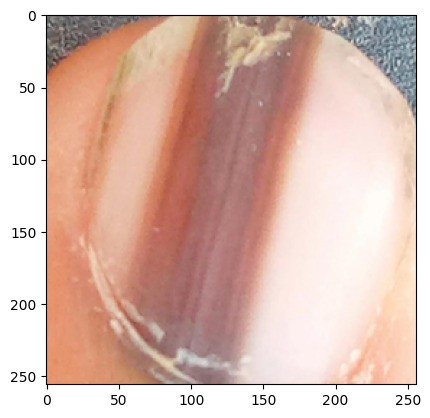

In [39]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [40]:
issues_count = 0

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            with Image.open(image_path) as img:
                img.verify()
                
                # Optional: get file extension check
                if img.format.lower() not in image_exts:
                    issues_count += 1
                    print(f"Image not in ext list {image_path}")
                    # os.remove(image_path)
        except Exception as e:
            issues_count += 1
            print(f"Issue with image {image_path}")
            print(e)
            # os.remove(image_path)

if issues_count == 0:
    print("No broken images found. Rejoice!")
else:
    print(f"There are {issues_count} broken images.")

No broken images found. Rejoice!


### **1.3. Load Data**

In [41]:
import numpy as np
from matplotlib import pyplot as plt

In [42]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
# data = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=False)
# data = data.shuffle(1000, seed=100, reshuffle_each_iteration=False)

Found 1600 files belonging to 2 classes.


In [43]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [44]:
# Class 0 = Healthy Nail
# Class 1 = Nail Melanoma
batch[1]

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

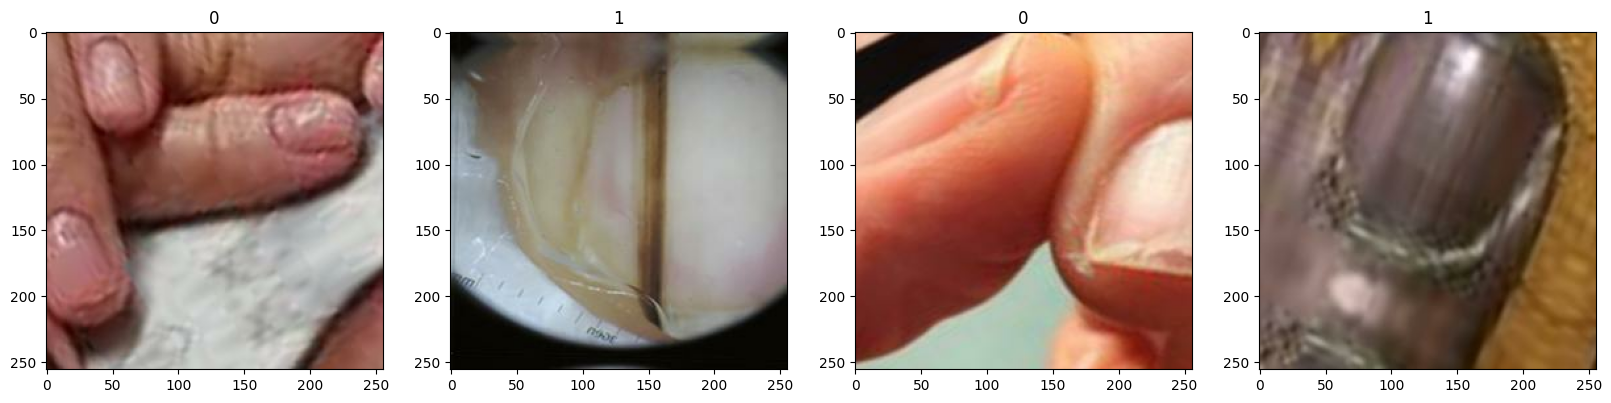

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## **2. Preprocess Data**

### **2.1. Scale Data**

In [46]:
# batch[0] are the images
# batch[1] are the labels
scaled = batch[0] / 255
scaled.max()

np.float32(1.0)

In [47]:
data = data.map(lambda img, label: (img / 255, label))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

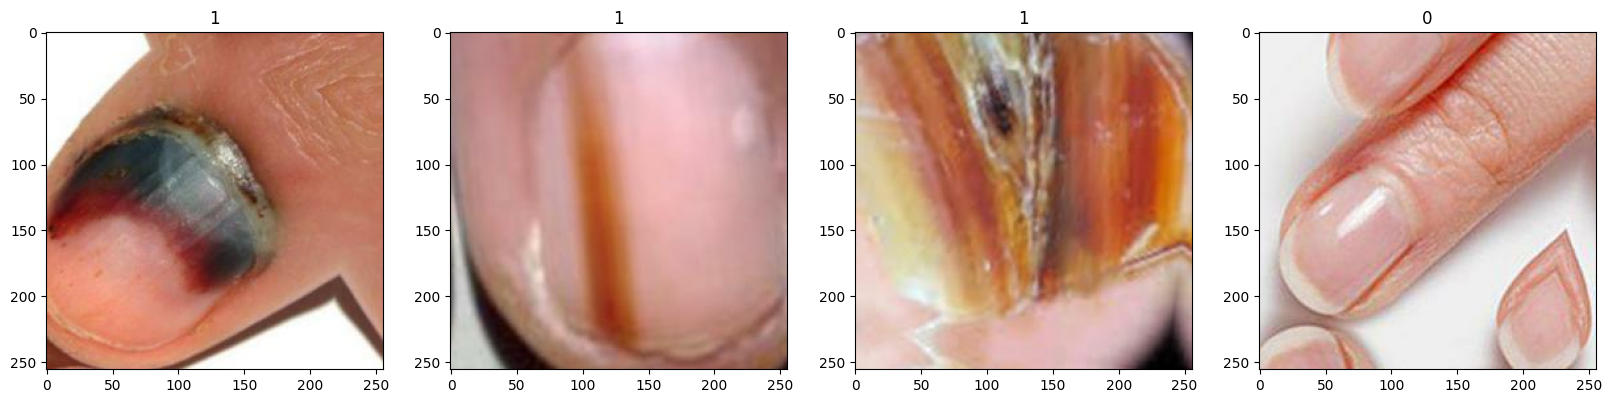

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### **2.2. Split Data**

In [49]:
# Display number of batches 50 * 32 = 1600
len(data)

50

In [50]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)  # Should be separate, not here

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## **3. Deep Model**

### **3.1. Build Deep Learning Model**

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [53]:
model = Sequential([
    Conv2D(16, (3, 3), strides=1, activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(),
    
    Conv2D(32, (3, 3), strides=1, activation="relu"),
    MaxPooling2D(),

    Conv2D(16, (3, 3), strides=1, activation="relu"),
    MaxPooling2D(),

    Flatten(),
    
    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

/home/faris/Programming/AI/cnn-nail/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### **3.2. Train**

In [56]:
log_dir="Logs"

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [58]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.5776 - loss: 0.7811 - val_accuracy: 0.6469 - val_loss: 0.5985
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.7046 - loss: 0.5757 - val_accuracy: 0.8062 - val_loss: 0.4570
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.7812 - loss: 0.4503 - val_accuracy: 0.7625 - val_loss: 0.5146
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8284 - loss: 0.4053 - val_accuracy: 0.8438 - val_loss: 0.3723
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8616 - loss: 0.3327 - val_accuracy: 0.8469 - val_loss: 0.3673
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.8969 - loss: 0.2715 - val_accuracy: 0.8438 - val_loss: 0.3914
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9191 - loss: 0.2364 - val_accuracy: 0.8156 - val_loss: 0.4034
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8989 - loss: 0.2752 - val_accuracy: 0.

### **3.3. Plot Performance**

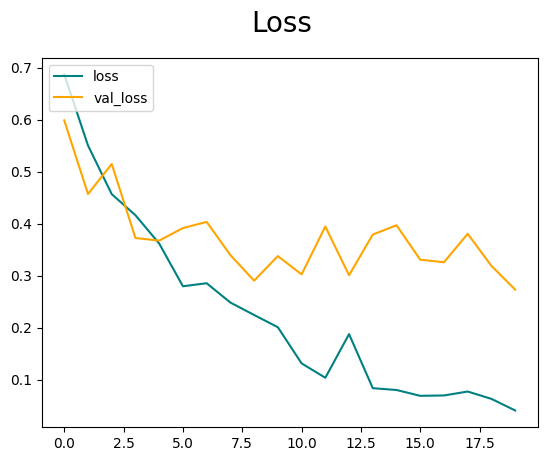

In [59]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

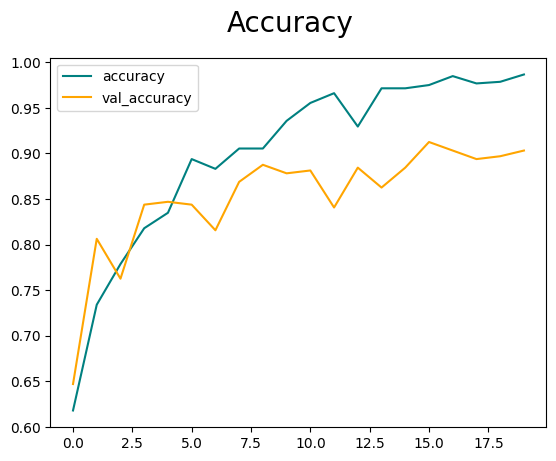

In [60]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

## **4. Evaluate Performance**

### **4.1. Evaluate**

In [61]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [62]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [63]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


2024-11-25 13:30:06.942641: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
print(f"Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}")

Precision: 0.9599999785423279, Recall: 0.8888888955116272, Accuracy: 0.925000011920929


### **4.2. Test**

In [65]:
import cv2

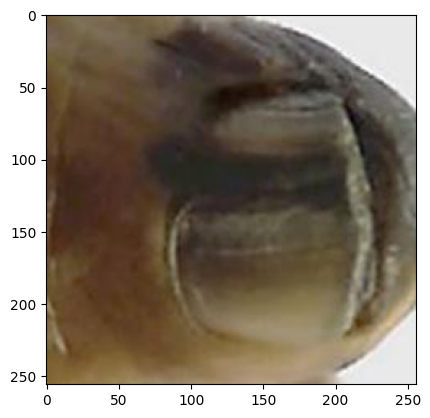

In [66]:
img = cv2.imread("Dataset/Original/Training/NailMelanoma/NailMelanoma (2).jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

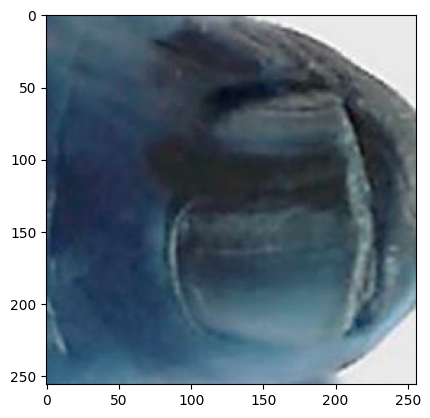

In [67]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [68]:
yhat = model.predict(np.expand_dims(resize / 255, 0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[1.]], dtype=float32)

## **5. Saving and Using the Model**

### **5.1. Save the Model**

In [69]:
import datetime
import random

current_date = datetime.datetime.now().strftime("%Y-%m-%d")
timestamp = datetime.datetime.now().strftime("%H%M%S")  # Hour, minute, second

filename = f"nail-model_{current_date}_{timestamp}.keras"

model.save(os.path.join("Models", filename))

print(f"Model saved as: {filename}")

Model saved as: nail-model_2024-11-25_133007.keras


### **5.2. Use the Model**

In [70]:

from tensorflow.keras.models import load_model
import os

loaded_model = load_model(os.path.join("Models", "nail-model_2024-11-24_171153.keras"))

/home/faris/Programming/AI/cnn-nail/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


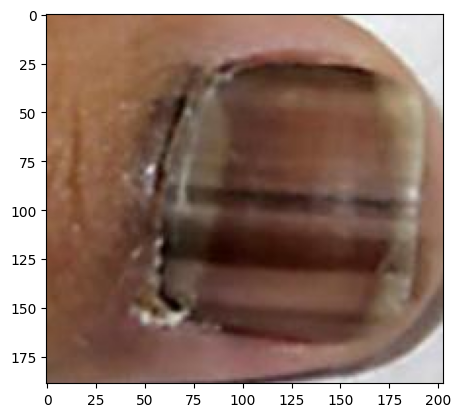

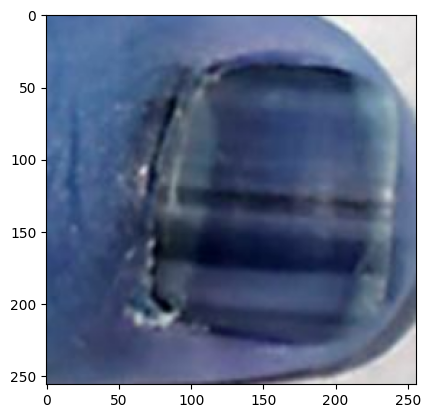

In [71]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

img = cv2.imread("Dataset/Original/Training/NailMelanoma/NailMelanoma (10).jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [72]:
import numpy as np

yhatnew = loaded_model.predict(np.expand_dims(resize / 255, 0))
yhatnew

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[1.]], dtype=float32)

In [ ]:
loaded_model??

Signature:   loaded_model(*args, **kwargs)
Type:        Sequential
String form: <Sequential name=sequential_3, built=True>
File:        ~/Programming/AI/cnn-nail/venv/lib/python3.12/site-packages/keras/src/models/sequential.py
Source:     
@keras_export(["keras.Sequential", "keras.models.Sequential"])
class Sequential(Model):
    """`Sequential` groups a linear stack of layers into a `Model`.

    Examples:

    ```python
    model = keras.Sequential()
    model.add(keras.Input(shape=(16,)))
    model.add(keras.layers.Dense(8))

    # Note that you can also omit the initial `Input`.
    # In that case the model doesn't have any weights until the first call
    # to a training/evaluation method (since it isn't yet built):
    model = keras.Sequential()
    model.add(keras.layers.Dense(8))
    model.add(keras.layers.Dense(4))
    # model.weights not created yet

    # Whereas if you specify an `Input`, the model gets built
    # continuously as you are adding layers:
    model = keras.Se